In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import uci_datasets

In [3]:

# Directory containing the CSV files
directory = '.'

# Initialize an empty list to store DataFrames
dfs = []

datasets = [name for name, (n_observations, n_dimensions) in uci_datasets.all_datasets.items() if 1 < n_observations < 50000]
#datasets =['gas', 'energy']

#datasets = ['gas']
# Iterate over the files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv') and 'split' in filename:
        global_entries = eval(filename.split('.csv')[0])
        if global_entries['dataset'] not in datasets:
            continue    
        if global_entries == -1: 
            continue

        # Read the CSV file into a DataFrame
        filepath = os.path.join(directory, filename)
        try:
            df = pd.read_csv(filepath)
        except:
            print(f"Error reading file: {filename}")
            continue
        
        if global_entries['standard_loss'] == 1:
            df['Train MSE'] = df['Train NN MSE']
            df['Test MSE'] = df['Test NN MSE']

        # Calculate sliding average for specified fields
        sliding_average_window = 1  # Specify the window size for the sliding average

        # Apply sliding average to the fields
        fields_to_average = ["Train loss", "Train MSE", "Test MSE"]
        df[fields_to_average] = df[fields_to_average].rolling(sliding_average_window, min_periods=1).mean()

        # Add columns for dataset
        for k, v in global_entries.items():
            df[k] = v
            
        # Append the DataFrame to the list
        dfs.append(df)

# Concatenate all DataFrames into a single DataFrameg
big_df = pd.concat(dfs, ignore_index=True)
group_by_keys = [k for k in global_entries.keys() if k != 'split'] + ["Epoch"]
grouped_df = big_df.groupby(group_by_keys).agg(['mean', 'std']).reset_index()

#print(grouped_df.to_markdown())

airfoil


/tmp/ipykernel_24477/1316648169.py:52: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  axs[i // 3, i % 3].set_ylim(mmin[metric], mmin[metric]*10.0)


concrete
energy
forest
gas
housing
pendulum
solar
stock
wine


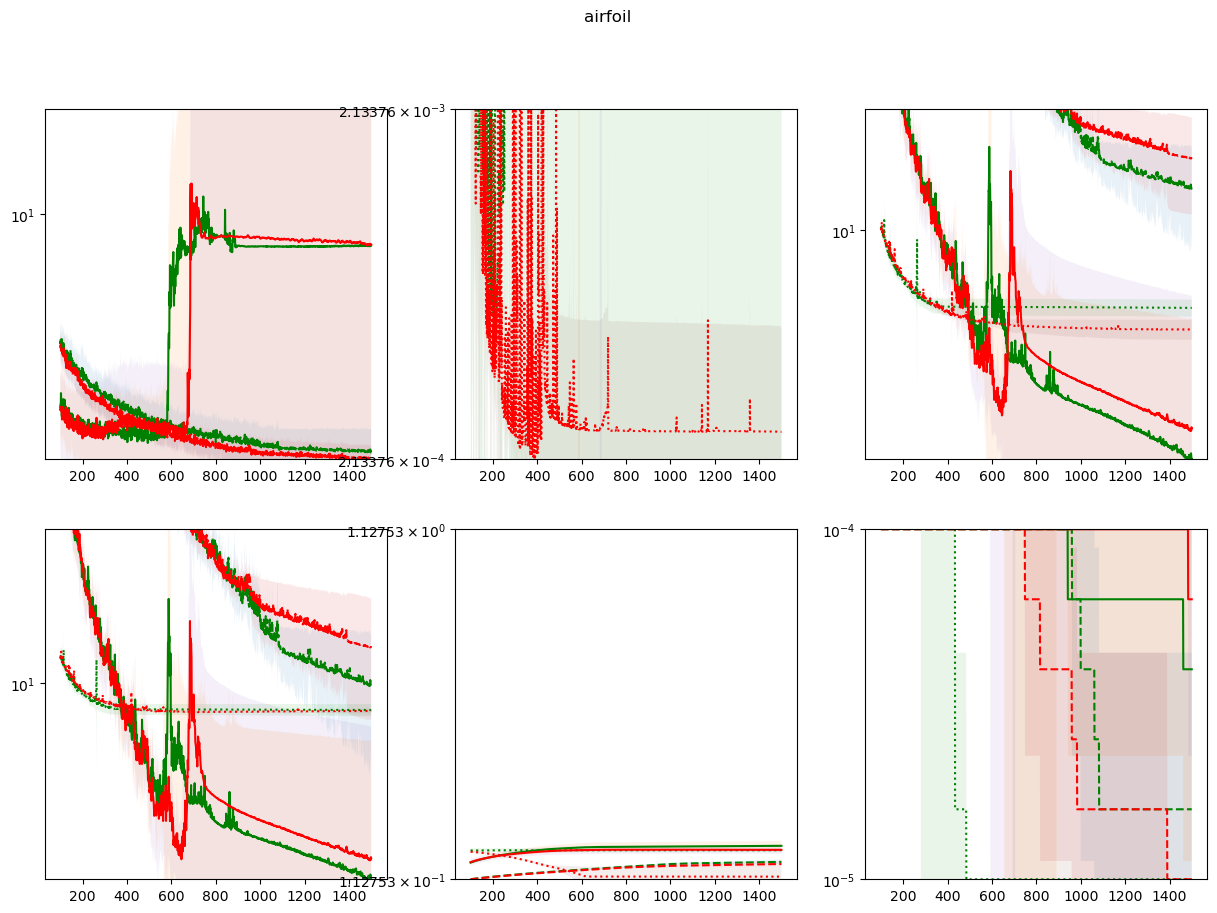

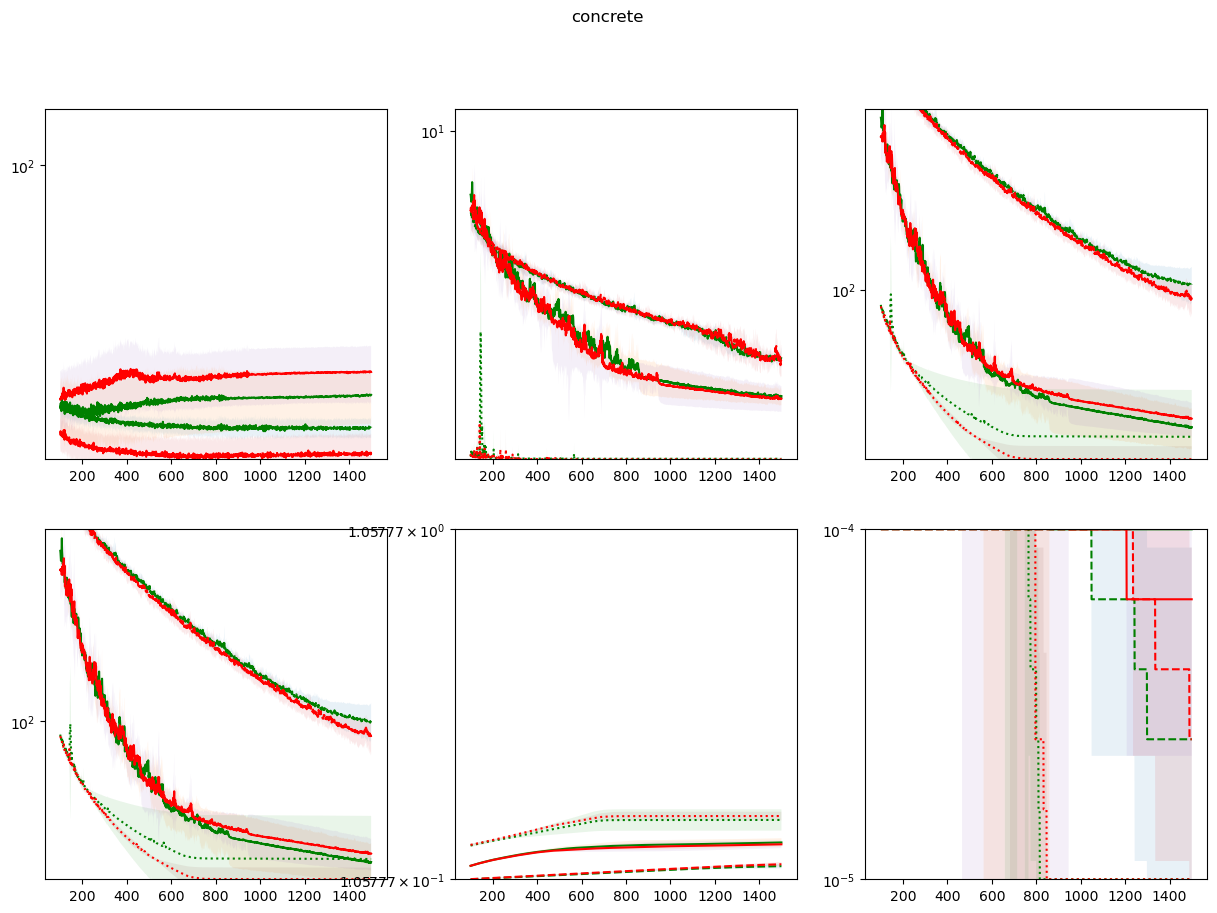

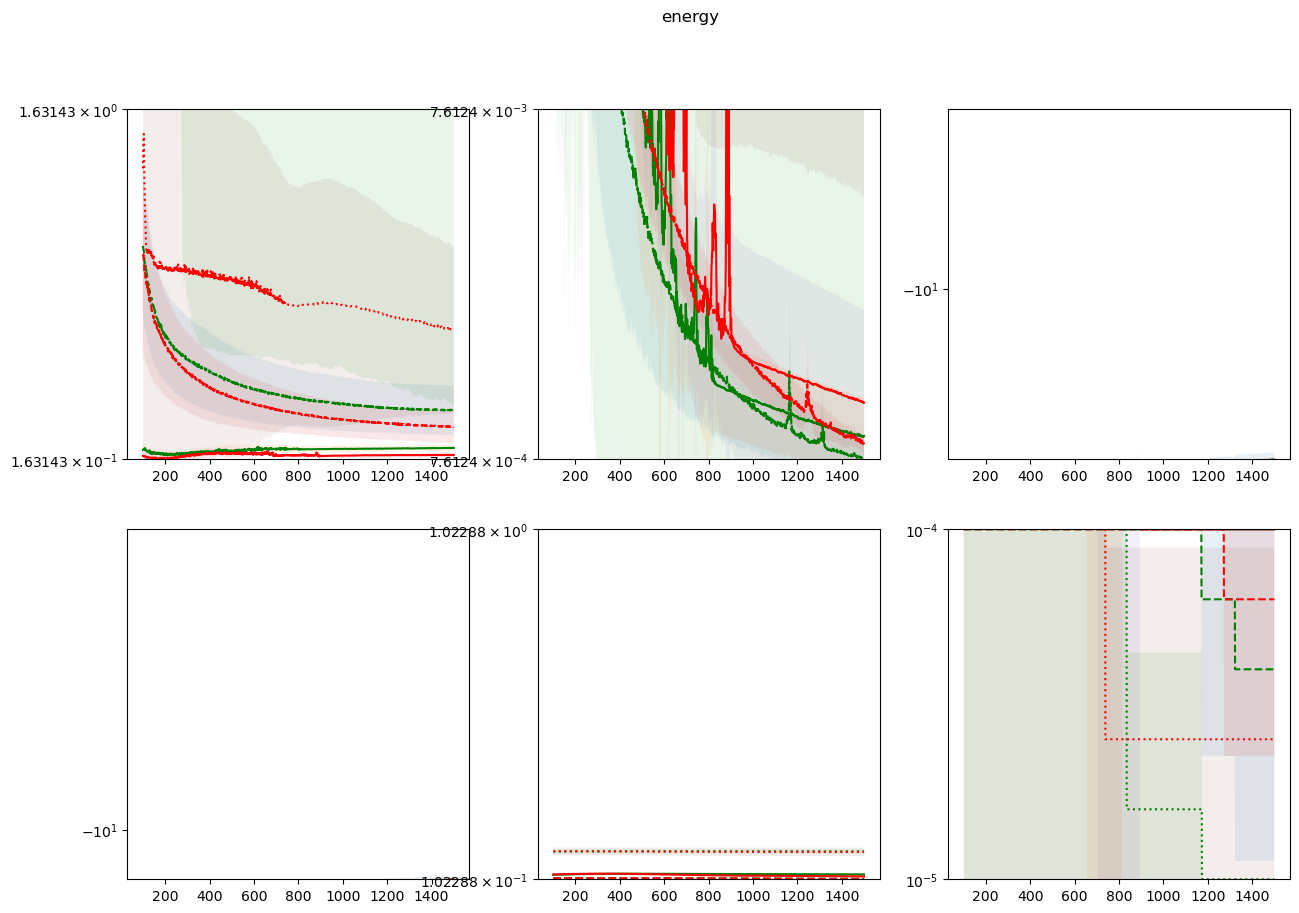

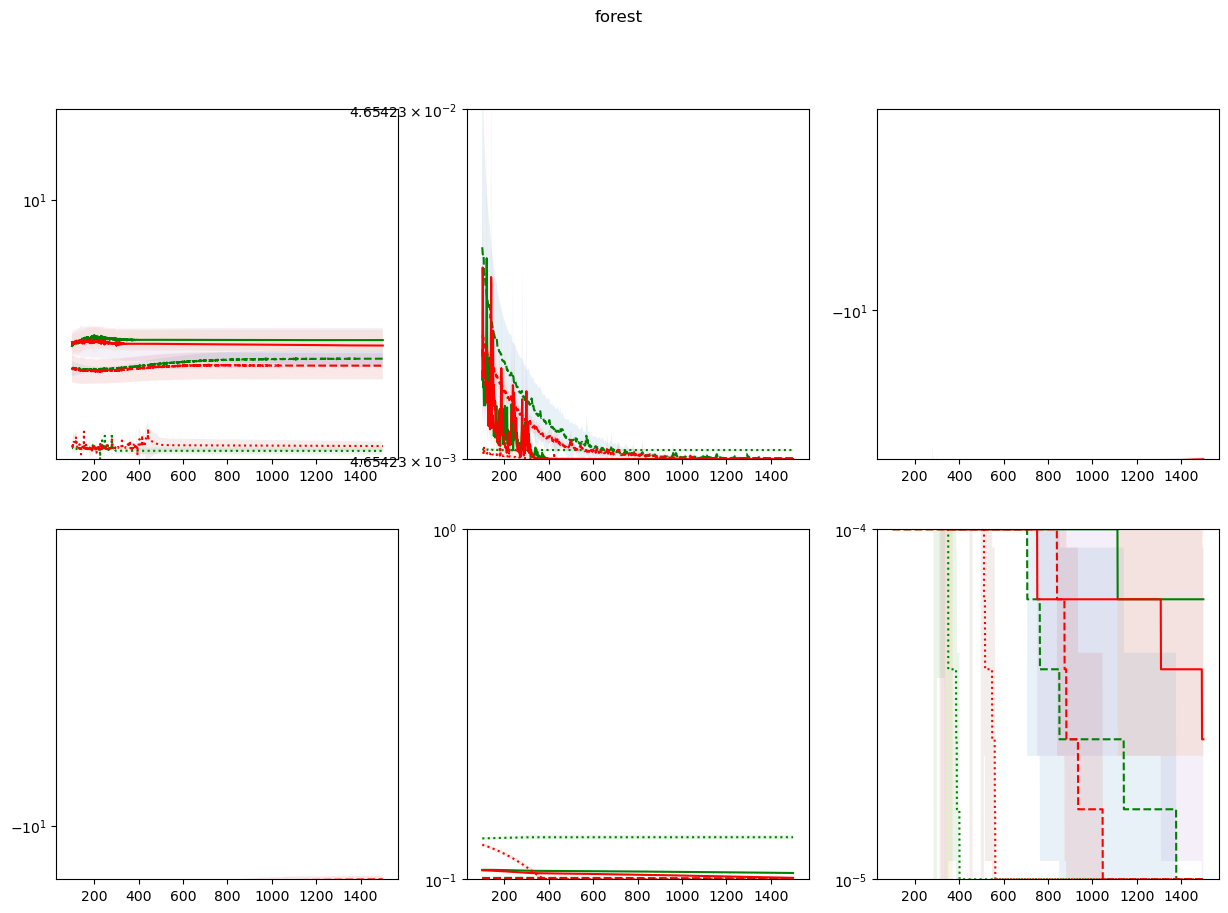

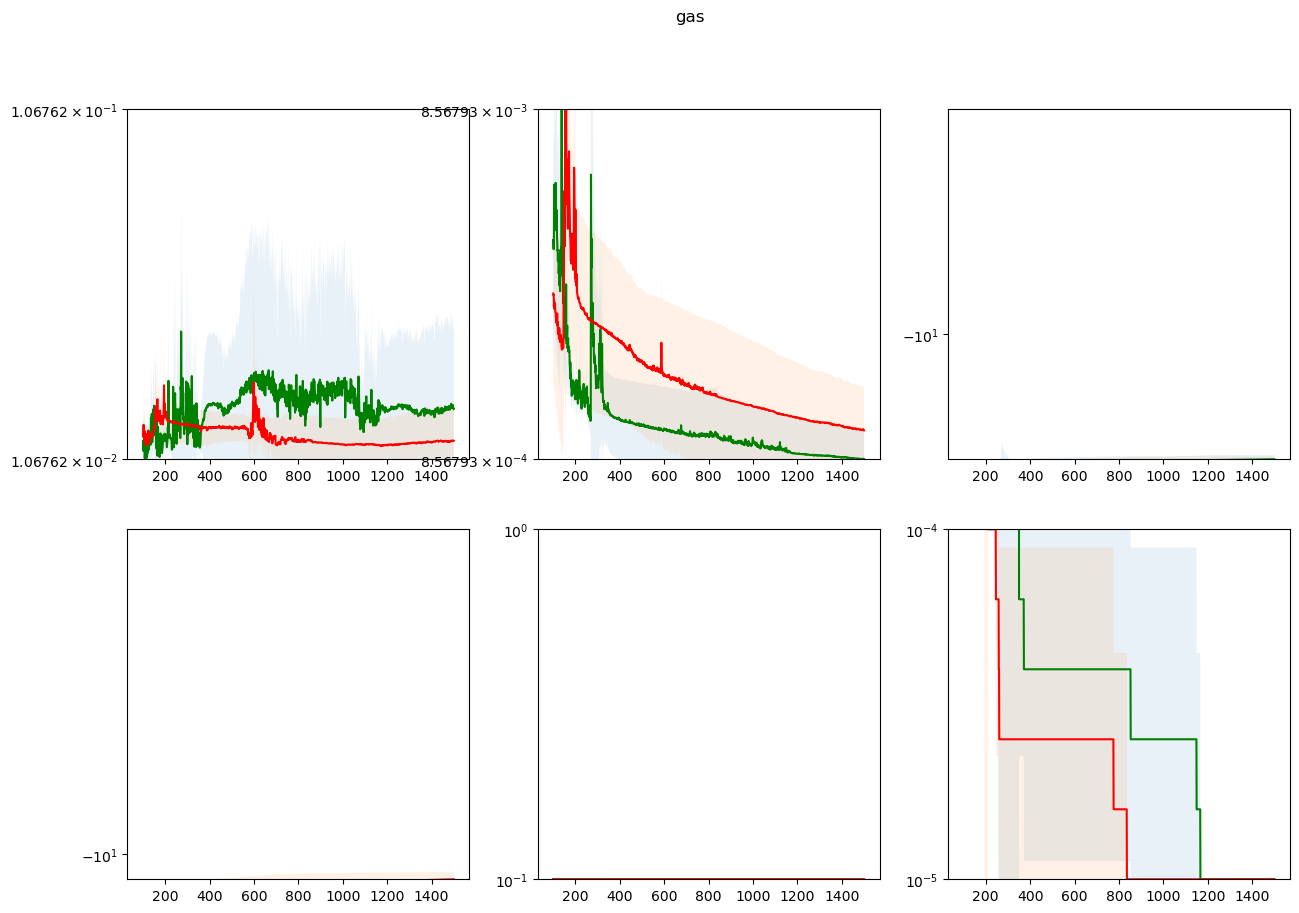

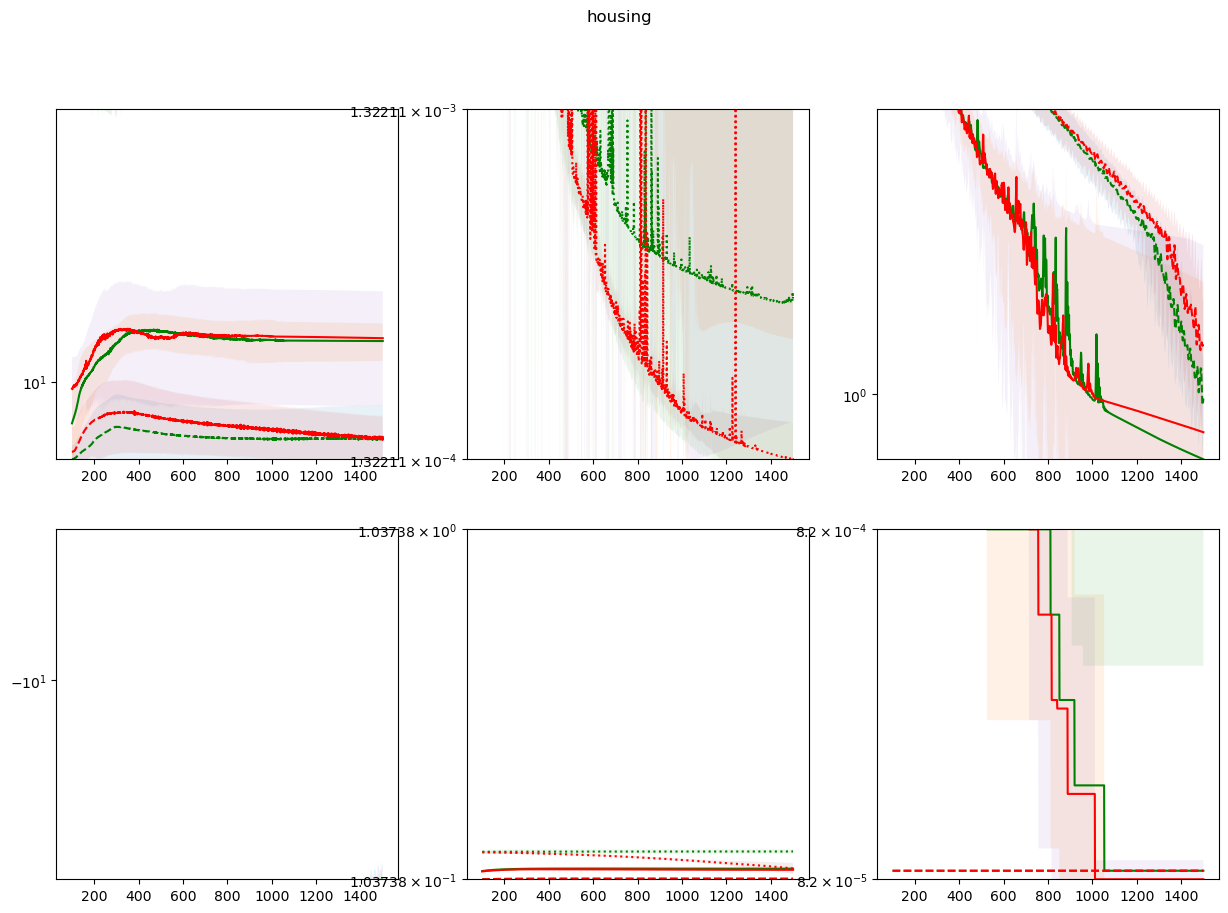

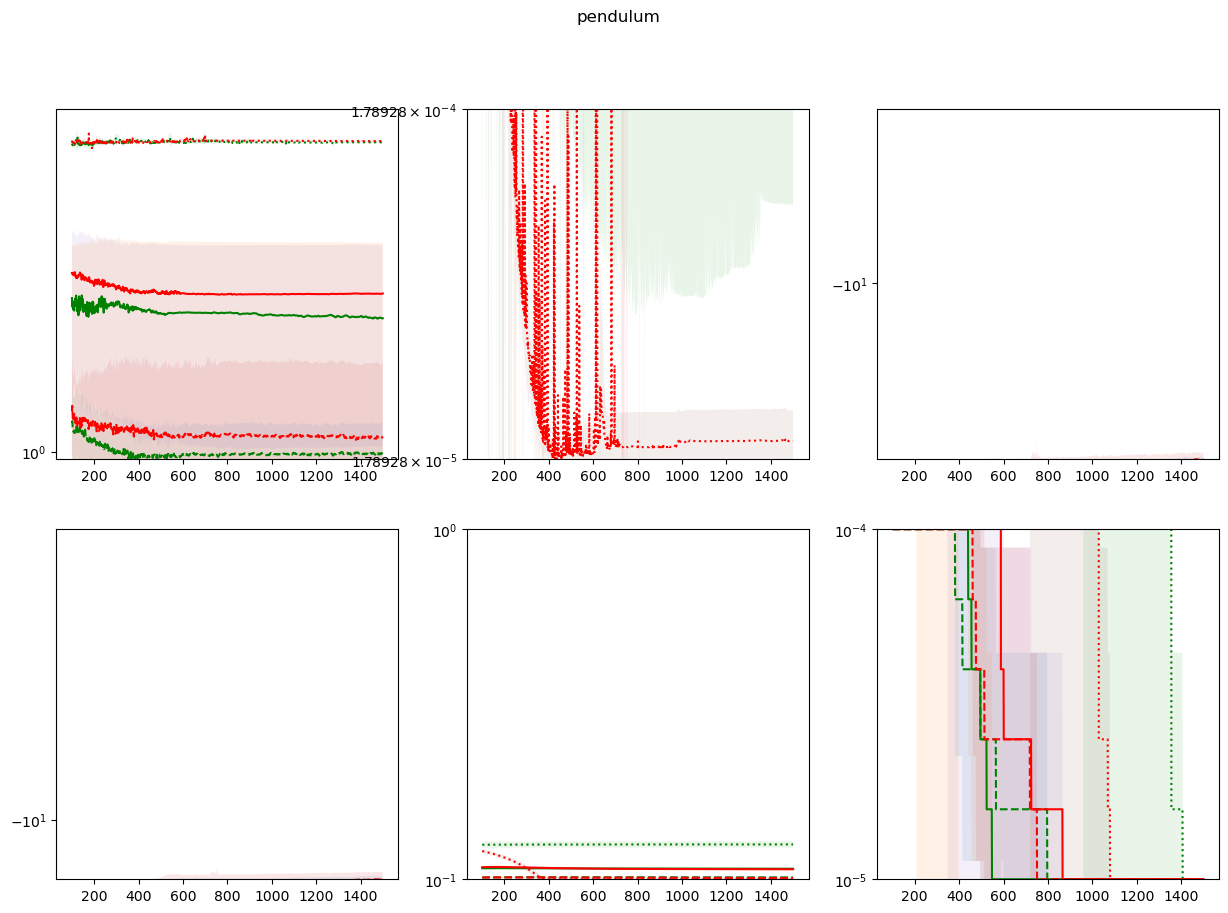

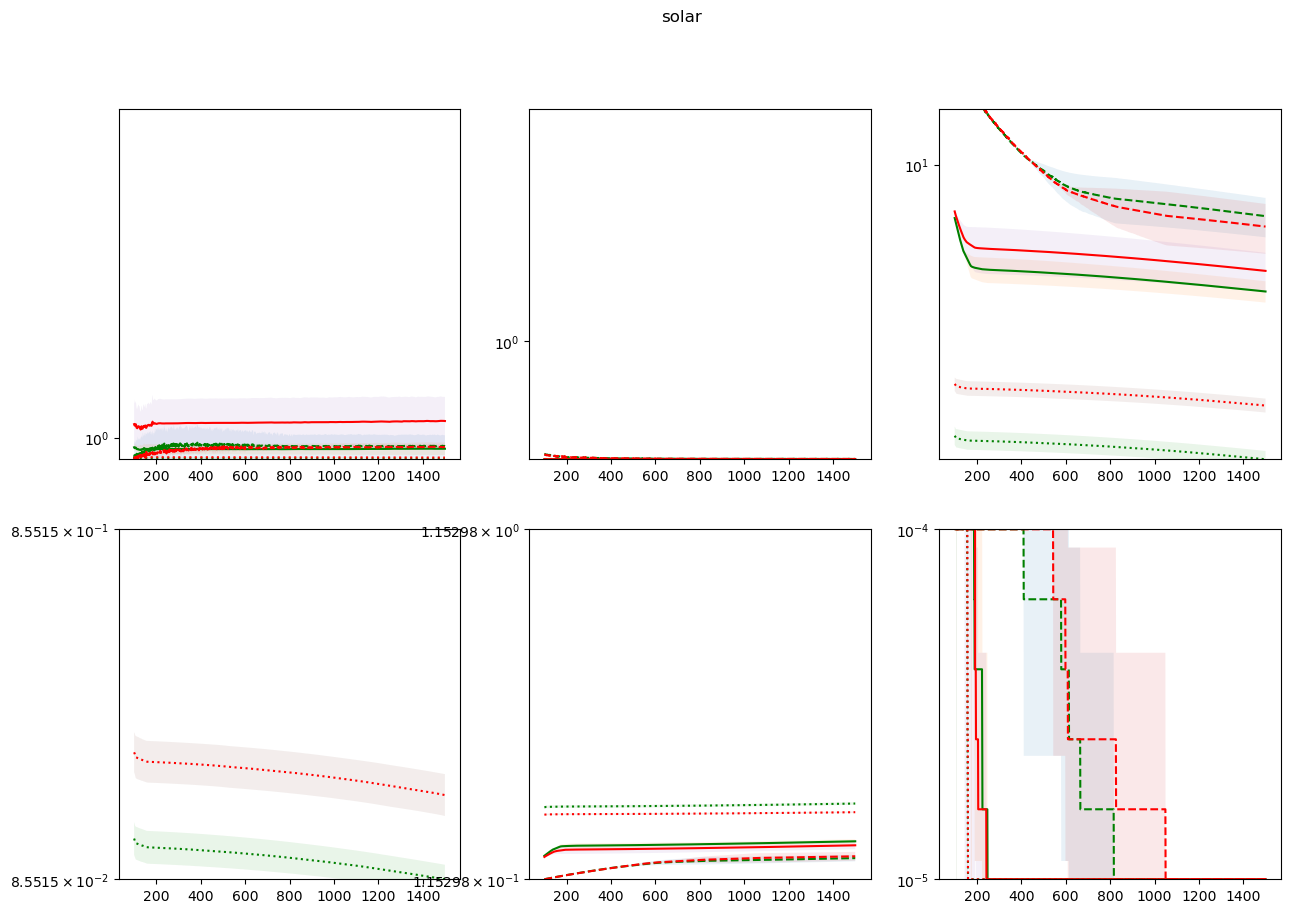

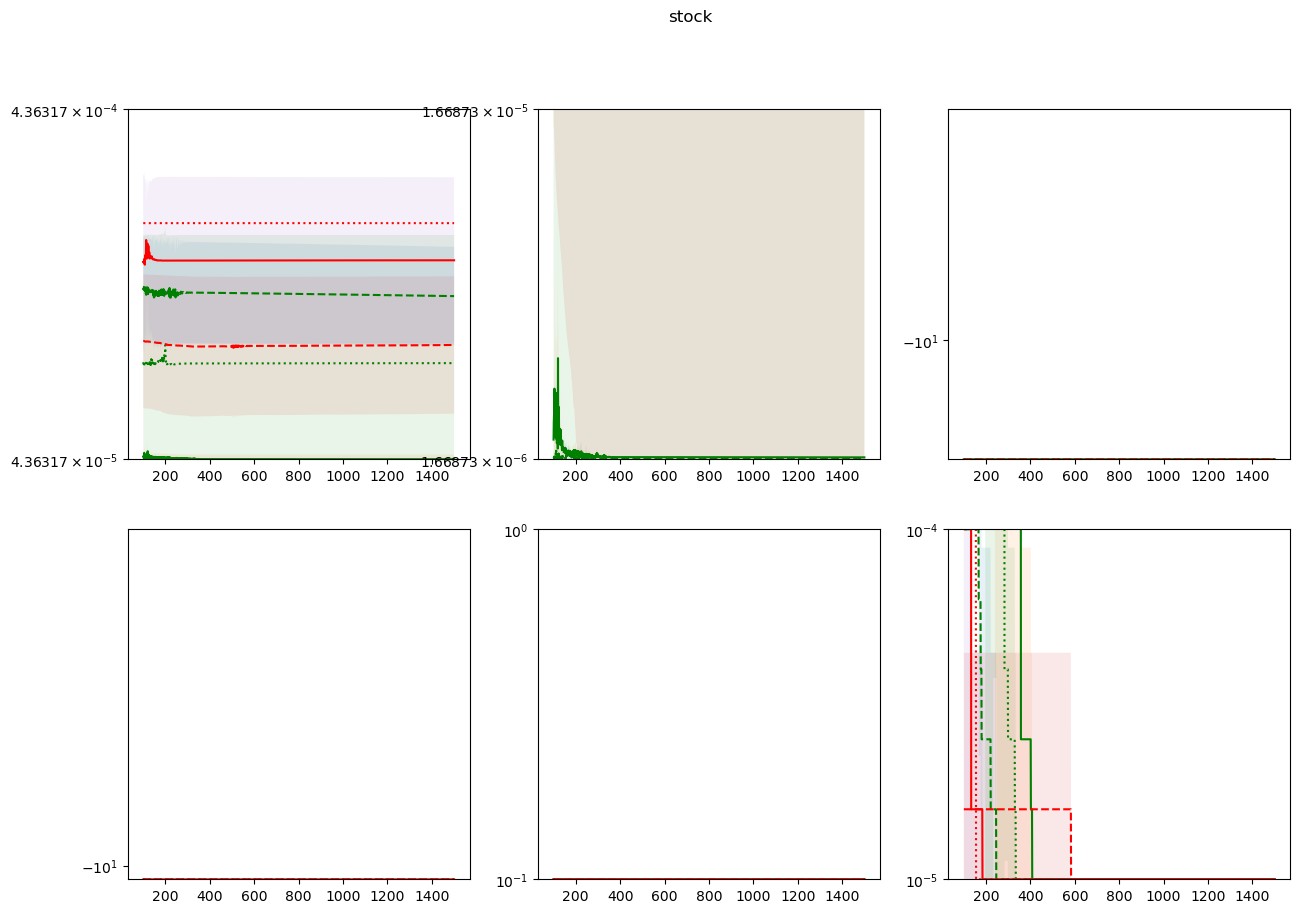

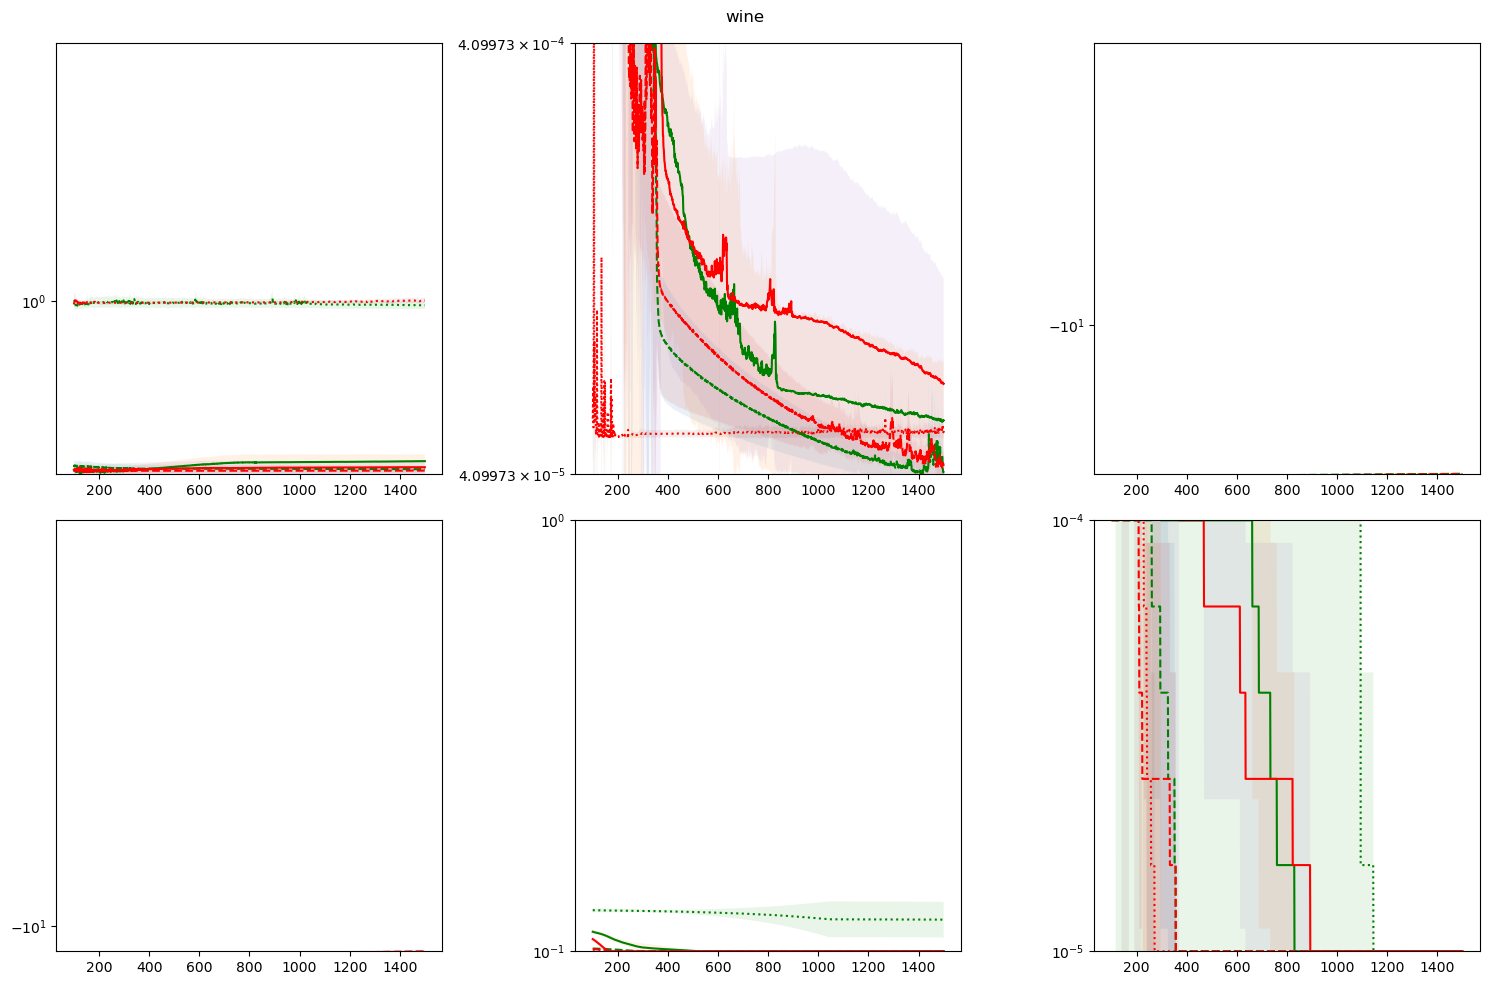

In [38]:
metrics = ['Test MSE', 'Train MSE', 'Train loss', 'Train loss2', 'sigma', 'Learning rate']
for dataset in grouped_df.dataset.unique():
    has_plot = False
    mmin = {}
    print(dataset)
    for optimize_logdet in [1]:#:grouped_df.optimize_logdet.unique():
        for optimize_logdet2 in grouped_df.optimize_logdet2.unique():
            for standard_loss in [0]:#grouped_df.standard_loss.unique() if not optimize_logdet else [0]:
                color = 'black' if standard_loss else \
                        'r' if optimize_logdet and optimize_logdet2 else \
                        'g' if optimize_logdet and not optimize_logdet2 else \
                        'b' #if not optimize_logdet and not optimize_logdet2
                if len(grouped_df[(grouped_df.dataset == dataset)
                                            & (grouped_df.optimize_logdet == optimize_logdet)
                                            & (grouped_df.standard_loss == standard_loss)].lr.unique()) <=1:
                                            #continue
                                            pass
                if not has_plot:
                    # create 6 subplots, 2 rows by 3 columns
                    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
                    fig.suptitle(dataset)
                    has_plot = True
                for l2_reg in grouped_df.l2_reg.unique():
                    for lr in  grouped_df.lr.unique():
                            df = grouped_df[(grouped_df.dataset == dataset)
                                            & (grouped_df.optimize_logdet == optimize_logdet)
                                            & (grouped_df.standard_loss == standard_loss)
                                            & (grouped_df.l2_reg == l2_reg)
                                            & (grouped_df.lr == lr)
                                            & (grouped_df.optimize_logdet2 == optimize_logdet2)
                                            & (grouped_df.Epoch >= 100)]
                            dash = ':' if lr == 0.01 else '-' if lr == 0.001 else '--'
                            # For each subplot, plot the mean values and fill between the (mean - std) and (mean + std) values
                            for i, metric in enumerate(metrics):
                                mean = df[(metric, 'mean')]
                                std = df[(metric, 'std')]
                                m = mean.min()
                                if pd.notnull(m):
                                    mmin[metric] = min(mmin[metric], m) if metric in mmin else m
                                    axs[i // 3, i % 3].plot(
                                        df['Epoch'], mean, color=color, linestyle=dash, label=f'{metric} [old={optimize_logdet} old2={optimize_logdet2} strd_loss={standard_loss} l2={l2_reg} lr={lr}]')
                                    axs[i // 3, i %3].fill_between(df['Epoch'], mean - std, mean + std, alpha=0.1)
                                    axs[i // 3, i % 3].set_yscale('symlog')
                                    #axs[i // 3, i % 3].legend()
                                #else:
                                #    print(f'nan in: dataset={dataset} optimize_logdet={optimize_logdet} optimize_logdet2={optimize_logdet2} standard_loss={standard_loss} l2_reg={l2_reg} lr={lr} metric={metric}')

                                


    for i, metric in enumerate(metrics):
        axs[i // 3, i % 3].set_ylim(mmin[metric], mmin[metric]*10.0)


plt.tight_layout()
plt.show()


In [68]:


df = grouped_df[grouped_df.Epoch==1480]
df.columns = [' '.join(col).strip() for col in df.columns.values]
#df = df[(df.standard_loss==0) & (df.optimize_logdet==1)]


group_keys = ['dataset', 'optimize_logdet', 'optimize_logdet2']

# Group the data by 'dataset', find the minimum 'mse' in each group
idx = df.groupby(group_keys)['Test MSE mean'].idxmin()

# Use the indices of the minimal 'mse' values to select the corresponding rows
minimal_mse_rows_per_method = df[['dataset', 'optimize_logdet', 'optimize_logdet2', 'standard_loss', 'lr', 'Test MSE mean']].loc[idx]

#idx = df.sort_values('Test MSE mean').groupby('dataset')['Test MSE mean'].nth()
#minimal_mse_rows = df[['dataset', 'optimize_logdet', 'optimize_logdet2', 'standard_loss', 'lr', 'Test MSE mean']].loc[idx]

#idx = df.sort_values(('Test MSE mean')).groupby(group_keys)[('Test MSE mean')].nth(1)
#second_minimal_mse_rows = df[['dataset', 'optimize_logdet', 'optimize_logdet2', 'standard_loss', 'lr', 'Test MSE mean']].loc[idx]


print(minimal_mse_rows_per_method.to_markdown())
#print(minimal_mse_rows.to_markdown())




|        | dataset   |   optimize_logdet |   optimize_logdet2 |   standard_loss |     lr |   Test MSE mean |
|-------:|:----------|------------------:|-------------------:|----------------:|-------:|----------------:|
|   7479 | airfoil   |                 0 |                  0 |               1 | 0.01   |     1.5957      |
|  10479 | airfoil   |                 1 |                  0 |               0 | 0.0001 |     2.11055     |
|  14979 | airfoil   |                 1 |                  1 |               0 | 0.0001 |     2.00923     |
|  19479 | concrete  |                 0 |                  0 |               0 | 0.0001 |    16.5608      |
|  28479 | concrete  |                 1 |                  0 |               0 | 0.0001 |    17.7305      |
|  32979 | concrete  |                 1 |                  1 |               0 | 0.0001 |    14.8137      |
|  43479 | energy    |                 0 |                  0 |               1 | 0.01   |     0.117767    |
|  47979 | energy  

In [69]:
def find_ratio(group):
    two_smallest = group['Test MSE mean'].nsmallest(2)
    ratio = two_smallest.iat[0] / two_smallest.iat[1] if len(two_smallest) >= 2 else np.nan
    other_fields = group.loc[two_smallest.idxmin(), ['dataset', 'optimize_logdet', 'optimize_logdet2', 'standard_loss', 'lr', 'Test MSE mean']]
    return pd.Series({'ratio': ratio, **other_fields})

ratios = df.groupby('dataset').apply(find_ratio)

print(ratios[ratios.ratio<0.98].to_markdown())

| dataset   |    ratio | dataset   |   optimize_logdet |   optimize_logdet2 |   standard_loss |     lr |   Test MSE mean |
|:----------|---------:|:----------|------------------:|-------------------:|----------------:|-------:|----------------:|
| airfoil   | 0.794183 | airfoil   |                 0 |                  0 |               1 | 0.01   |     1.5957      |
| concrete  | 0.894499 | concrete  |                 1 |                  1 |               0 | 0.0001 |    14.8137      |
| energy    | 0.880781 | energy    |                 0 |                  0 |               1 | 0.01   |     0.117767    |
| gas       | 0.612542 | gas       |                 1 |                  1 |               0 | 0.001  |     0.0154539   |
| pendulum  | 0.705708 | pendulum  |                 0 |                  0 |               1 | 0.001  |     0.388819    |
| solar     | 0.800776 | solar     |                 0 |                  0 |               1 | 0.1    |     0.690312    |
| stock     | 0.